In [1]:
%pylab inline
import sys
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
np.random.seed(1)
font = {'family' : 'sans-serif',
        'sans-serif': 'arial',
        'weight' : 'normal',
        'size'   : 9}

mpl.rc('font', **font)
mpl.rc('text', usetex=False)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


In [2]:
def jackknife( data_array ):
    from math import sqrt
    """ Return the jackknife standard deviation given a numpy array of samples. The formula is given by
        sig^2 = (N-1) sum_i ( ( mu_i - mu )^2 / N )
        where mu = 1/N sum data(i)
        and mu_i = 1/(N-1) ( ( sum_j data(j) ) - data(i) )
        see e.g.: http://www.physics.utah.edu/~detar/phycs6730/handouts/jackknife/jackknife/
    """
    N = len(data_array)
    m = data_array.mean()
    s = data_array.sum()
    sum = 0
    for i in range(N):
        mi = ( s - data_array[i] ) / (N - 1.)
        sum = sum + ( mi - m )**2 /float(N)

    sig2 = (N-1.) * sum

    return sqrt(sig2)

#based on bootstrap hist in /home/glen842/tools/data_tools.py
def bootstrap_ratio(data_list,nrepeats=300,nbins=2,bins_in=None,density=True):
    import numpy as np
    data_list = np.array(data_list)
    if bins_in is None:
        bins = nbins
    else:
        bins = bins_in
    hist,bins_total = np.histogram(data_list,bins=bins,density=density)
    nsamples = len(data_list)
    hist_list = []
    ratio_list = []
    for i in range(nrepeats):
        randidx = np.random.randint(0,nsamples,size=nsamples)
        new_data = data_list[randidx]
        hist,bins = np.histogram(new_data,density=density,bins=bins_total)
        hist_list.append(hist)
        #note, this is diff to same
        ratio_list.append(hist[1]/hist[0])
    hist_array = np.array(ratio_list)
    hist_mean = np.mean(hist_array,axis=0)
    hist_std = np.std(hist_array,axis=0)
    return ba(bins_total), hist_mean, hist_std, bins_total

In [3]:
#define variables 
outdir = None
if outdir is not None:
    !mkdir -p {outdir}

#nm
site_width = 35.
#actinin -fascin
dxl = 37.-8.

In [4]:
def f(x,Lp):
    Lp_sites = Lp*1e3/site_width
    return Lp_sites/x*(np.arcsin((dxl/site_width)/x)**2)

#A is the equilibrium ratio, kother/ksame
def ratio_at_dist(x,onleft,kon1,kon2,Lp):
    #0 on left
    #1 on left
    prefactor = (onleft==1)*kon2/kon1 + (onleft==2)*kon1/kon2
    return prefactor*exp(-f(x,Lp))

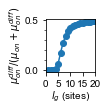

In [5]:
n_binding_sites = 20
binding_sites = np.arange(1,n_binding_sites+1,1.)
dist_ratio = ratio_at_dist(binding_sites,onleft=1,kon1=1,kon2=1,Lp=17)
p_switch = dist_ratio/(1+dist_ratio)

myfig = figure(figsize=(1.6,1.5))
ax = plt.gca()
plot(binding_sites,p_switch,marker='o')
ylabel("$\mu_{on}^{diff}/(\mu_{on}+\mu_{on}^{diff})$",labelpad=1)
xlabel('$l_g$ (sites)',labelpad=1)
xlim(0,20)
xticks(np.arange(0,25,5))
ax.set_yticks(np.arange(0,1,.5),minor=False)
ax.set_yticks(np.arange(0,0.6,.1),minor=True)

tight_layout()
if outdir is not None: savefig(os.path.join(outdir,'on_rate_ratio.pdf'), transparent='true')

Running until length reaches 15.000000 microns / 428 sites
starting with type 1


(0.005847953216374269,
 0.0,
 array([ 3325., 11865.]),
 array([1, 2]),
 array([1.04598417e+01, 5.31981003e+00, 2.34782857e+00, 9.82558064e-01,
        4.39124079e+00, 3.48397340e+00, 2.24731117e+00, 3.93795047e-01,
        5.34144779e+00, 5.09252348e-01, 9.06773331e-01, 3.00858845e+00,
        4.03016747e+00, 4.37215824e+00, 3.91500236e+00, 2.04529842e+00,
        9.77345132e-02, 2.86476546e+00, 1.22959698e-01, 2.38956679e+00,
        3.83067616e+00, 2.46737129e+00, 5.31803351e+00, 2.08497162e-01,
        3.42272243e+00, 5.28486574e-01, 3.74307294e+00, 2.47724671e+00,
        2.37359351e+00, 1.59959185e+00, 1.45896733e+00, 3.82010693e+00,
        4.12614870e+00, 6.65910408e+00, 7.84394023e-01, 3.17162456e+00,
        2.90374093e+00, 7.24620405e-01, 2.25019489e+00, 1.68234037e+00,
        1.00518165e+00, 1.97551930e+00, 3.36072857e+00, 2.85784786e+00,
        7.33191796e-01, 8.57472746e-01, 6.69786910e-01, 8.48291424e-01,
        1.86574363e+00, 8.04625857e-01, 4.45658684e+00, 7.4239885

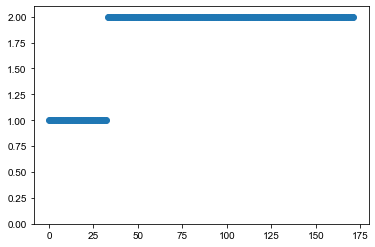

In [6]:
def rates(n_rate_sites,onleft,kon1,kon2,Lp):
    rate_list = []
    for i in range(1,n_rate_sites+1):
        p_diff = ratio_at_dist(i,onleft,kon1,kon2,Lp)
        if onleft==1:
            rate_list.append(kon1)
            rate_list.append(p_diff*kon1)
        elif onleft==2:
            rate_list.append(p_diff*kon2)
            rate_list.append(kon2)
        else:
            assert onleft in (1,2),"on_left is not either 1 or 2"
    return np.array(rate_list)

#extension rate is in nm/second
#max length in nm
def extension_population_ratio(num_trials=1,max_filament_length=15000,extension_rate=10, kon1=0.1,kon2=0.1, 
                               showplot=False,Lp=17,n_sites_init=0,max_extensions=200):
    
    site_extension_rate = float(extension_rate)/site_width
    assert extension_rate>0,"bundle has to be growing"
    max_n_sites = int(max_filament_length/site_width)
    print("Running until length reaches %f microns / %i sites"%(max_filament_length/1000,max_n_sites))

    # n_rate_sites is the distance out to which to compute a rate
    n_rate_sites = max_extensions+1
    
    #1 list for 1 on right, another for 2 on right
    rate_list = [rates(n_rate_sites,onleft=1,kon1=kon1,kon2=kon2,Lp=Lp), 
                rates(n_rate_sites,onleft=2,kon1=kon1,kon2=kon2,Lp=Lp)]
    
    prob_type_1 = kon1/(kon1+kon2)
    n_keep_list = np.zeros(num_trials)
    n_swap_list = np.zeros(num_trials)
    domain_length_list = []
    domain_type_list = []
    all_swap_list = []
    all_types_chosen = []
    all_bundle_extension_rates = []

    
    nsites_needed = []
    times_chosen = []
    sites_chosen = []
    events_chosen = []
    
        
    for i in range(num_trials):
        current_site = 0
        filament_length = 0

        occupation_lattice = np.zeros(max_n_sites,dtype=int)
        current_type = 1+(np.random.random()>prob_type_1)
        occupation_lattice[current_site] = current_type
        
        if showplot: print("starting with type",current_type)
        t = 0
        
        filament_lengths = []
        swap_list = []
        types_chosen = []
        bundle_extension_rates = []

        n_sites_away = n_sites_init
        
        while(filament_length<max_filament_length):
            unbound = True
            prev_t = t
            sites_added = 0
            while unbound and n_sites_away < max_extensions:
                tmp_rate_list = np.append(rate_list[current_type-1][:2*n_sites_away],site_extension_rate)
                #if t<100: print(tmp_rate_list)
                tmp_cum_rate = tmp_rate_list.cumsum()
                r1,r2 = np.random.random(size=2)
                event_chosen = np.searchsorted(tmp_cum_rate, r1*tmp_cum_rate[-1])
                t = t - np.log(r2)/tmp_cum_rate[-1]
                if event_chosen == len(tmp_rate_list)-1:  
                    sites_added += 1
                    n_sites_away += 1
                    filament_length += site_width
                else:
                    unbound = False
                assert n_sites_away < max_extensions, "error, max extensions reached"

            events_chosen.append(event_chosen)
            times_chosen.append(t-prev_t)
            nsites_needed.append(sites_added)
               
            sites_chosen.append((event_chosen//2)+1)
            types_chosen.append((event_chosen%2)+1)
            current_site += sites_chosen[-1]
            n_sites_away = n_sites_away - sites_chosen[-1]
            
            bundle_extension_rates.append(sites_chosen[-1]*site_width/times_chosen[-1])

            if current_site < len(occupation_lattice):
                occupation_lattice[current_site] = types_chosen[-1]
            swap_list.append(int(current_type!=types_chosen[-1]))
            current_type = types_chosen[-1]
            filament_lengths.append(filament_length)
            
        
        swap_array = np.array(swap_list)
        if np.sum(swap_array)>0:
            filament_length_at_swap_array = np.array(filament_lengths)[swap_array==1]
            #have to add in edge domains
            domain_lengths = np.insert( filament_length_at_swap_array[1:]-filament_length_at_swap_array[:-1],0,filament_length_at_swap_array[0])
            domain_lengths = np.insert( domain_lengths,len(domain_lengths),filament_lengths[-1]-filament_length_at_swap_array[-1])
            domain_types = np.insert( np.array(types_chosen)[swap_array==1], 0, occupation_lattice[0] )
        else:
            domain_lengths = [filament_length]
            domain_types = [occupation_lattice[0]]
        domain_length_list.extend(domain_lengths)
        domain_type_list.extend(domain_types)            
        
        if showplot is True:
            figure()
            #plot(occupation_lattice,marker='o',linestyle='')
            plot(types_chosen,marker='o',linestyle='')
            ylim(0,2.1)
        n_keep_list[i]=(swap_array==0).sum()
        n_swap_list[i]=(swap_array==1).sum()
        all_swap_list.extend(swap_list)
        
        types_chosen = np.array(types_chosen)
        all_types_chosen.extend(types_chosen)
        all_bundle_extension_rates.append(
            (np.array(bundle_extension_rates)[types_chosen==1],
             np.array(bundle_extension_rates)[types_chosen==2])
        )

    swap_ratio = np.mean(n_swap_list/n_keep_list)
    swap_ratio_std = np.std(n_swap_list/n_keep_list)
    return swap_ratio,swap_ratio_std,np.array(domain_length_list),np.array(domain_type_list), \
               np.array(times_chosen),np.array(all_swap_list),np.array(sites_chosen),all_bundle_extension_rates
                    


extension_population_ratio(num_trials=1,kon1=.2,kon2=.2,extension_rate=40,showplot=True)
    

Running until length reaches 15.000000 microns / 428 sites


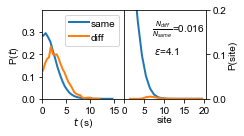

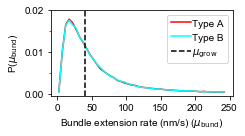

In [7]:
#bin average
def ba(bins):
    return (bins[1:]+bins[:-1])/2.0

fig, ax = subplots(1,2,figsize=(3.5,2),sharey=False)
extension_rate = 40.
ratio, ratio_std, _,_, times_chosen, event_type_chosen, sites_chosen, all_bundle_extension_rates = extension_population_ratio(num_trials=1000,kon1=0.2,kon2=0.2,
                                                                            extension_rate=extension_rate,showplot=False)
num_trials = len(sites_chosen)

time_hist_same, time_bins_same = np.histogram(times_chosen[event_type_chosen==0],density=True,bins=30)
time_hist_diff, time_bins_diff = np.histogram(times_chosen[event_type_chosen==1],density=True,bins=30)


ax[0].plot(ba(time_bins_same),time_hist_same,label='same',lw=2)
ax[0].plot(ba(time_bins_diff),time_hist_diff,label='diff',lw=2)
ax[0].set_ylim(0,0.4)

ax[0].set_ylabel('P($t$)',labelpad=0)
ax[0].set_xlabel('$t$ (s)',labelpad=0)
ax[0].set_xlim(0,17)
ax[0].set_xticks(np.arange(0,19,5))
ax[0].set_yticks(np.arange(0,0.35,.1))


ax[0].legend(loc=0,fontsize=10,handletextpad=0.1)

   
same_hist, same_bins = np.histogram( sites_chosen[event_type_chosen==0], density=False, bins=binding_sites )
diff_hist, diff_bins = np.histogram( sites_chosen[event_type_chosen==1], density=False, bins=binding_sites )

ax[1].plot(ba(same_bins), same_hist/float(num_trials), label='same',lw=2)
ax[1].plot(ba(diff_bins), diff_hist/float(num_trials), label='diff',lw=2)


ax[1].set_xlabel('site',labelpad=0)
ax[1].set_ylabel('P(site)',labelpad=2)

ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_ylim(0,0.2)

ax[1].set_yticks(np.arange(0,0.25,0.1))
ax[1].set_xticks(np.arange(0,25,5))

ax[1].annotate('$\\frac{N_{diff}}{N_{same}}$=%.3f'%ratio,xy=(7,0.15),fontsize=10)
ax[1].annotate('$\epsilon$=%.1f'%-log(ratio),xy=(7.5,0.1),fontsize=10)
tight_layout()
fig.subplots_adjust(hspace=0,wspace=0)

if outdir is not None:  savefig(os.path.join(outdir,'example_pbind_mugrow40_kon0.2.pdf'),transparent='true')

plt.figure(figsize=(3.5,2))
#this is a slight approximation, since the times for extending ignore insertions into already formed gaps
type_A_extension_rates = np.concatenate([ x[0][np.nonzero(x[0])] for x in all_bundle_extension_rates])
type_B_extension_rates = np.concatenate([ x[1][np.nonzero(x[1])] for x in all_bundle_extension_rates])
time_bins = np.arange(0,250,5)
A_extension_hist, _ = np.histogram( type_A_extension_rates, density=True, bins=time_bins)
B_extension_hist, _ = np.histogram( type_B_extension_rates, density=True, bins=time_bins)
plt.plot(ba(time_bins),A_extension_hist,color='red',label='Type A')
plt.plot(ba(time_bins),B_extension_hist,color='cyan',label='Type B')
plt.axvline(extension_rate,label='$\\mu_\mathrm{grow}$',color='k',linestyle='--')
plt.xlabel('Bundle extension rate (nm/s) ($\\mu_\mathrm{bund}$)')
plt.ylabel('P($\\mu_\mathrm{bund}$)')
ax=plt.gca()
ax.set_yticks(np.arange(0,0.025,.01))
ax.set_yticks(np.arange(0,.025,0.005),minor=True)
plt.legend(loc=0,fontsize=10,handletextpad=0.1)
plt.tight_layout()
if outdir is not None:  savefig(os.path.join(outdir,'example_bundle_extension_mugrow40_kon0.2.pdf'),transparent='true')


Running until length reaches 15.000000 microns / 428 sites
Running until length reaches 15.000000 microns / 428 sites
Running until length reaches 15.000000 microns / 428 sites
Running until length reaches 15.000000 microns / 428 sites
Running until length reaches 15.000000 microns / 428 sites


/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


Running until length reaches 15.000000 microns / 428 sites
Running until length reaches 15.000000 microns / 428 sites
Running until length reaches 15.000000 microns / 428 sites
Running until length reaches 15.000000 microns / 428 sites
Running until length reaches 15.000000 microns / 428 sites
Running until length reaches 15.000000 microns / 428 sites
Running until length reaches 15.000000 microns / 428 sites
Running until length reaches 15.000000 microns / 428 sites
Running until length reaches 15.000000 microns / 428 sites
Running until length reaches 15.000000 microns / 428 sites
Running until length reaches 15.000000 microns / 428 sites
Running until length reaches 15.000000 microns / 428 sites
Running until length reaches 15.000000 microns / 428 sites
Running until length reaches 15.000000 microns / 428 sites
Running until length reaches 15.000000 microns / 428 sites
Running until length reaches 15.000000 microns / 428 sites
Running until length reaches 15.000000 microns / 428 sit

(0, 0.1)

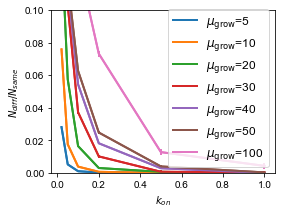

In [9]:
extension_rates = (5.0,10.,20.,30.,40.,50.,100.)
kons = (0.02,0.05,0.1,0.2,0.5,1.0)
my_num_trials=10
all_energies = []
#all_times = []
figure(figsize=(4,3))
for extension_rate in extension_rates:
    ratios = []
    ratio_stds =[]
    energies = []
    #times = []
    for kon in kons:
        #ratio, ratio_std, times,types,sites = extension_population_ratio(extension_rate=extension_rate,
        #                                                           kon=kon,num_trials=50000)
        ratio, ratio_std,_,_,_,_,_,_ = extension_population_ratio(num_trials=my_num_trials,extension_rate=extension_rate,
                                                                   kon1=kon,kon2=kon)
        ratios.append(ratio)
        ratio_stds.append(ratio_std)
        energies.append(-np.log(ratio))
    #plot(kons,energies,label="v_pol=%.2f"%extension_rate)
    myplt = plot(kons,ratios,lw=2,label="$\\mu_\mathrm{grow}$=%.f"%extension_rate)
    errorbar(kons,ratios,ratio_std,lw=2,c=myplt[0].get_c())

    all_energies.append(energies)
    #all_times.append(times)

ylabel("$N_{diff}/N_{same}$")
xlabel('$k_{on}$')
legend(loc=0,fontsize=12)
ylim(0,0.1)

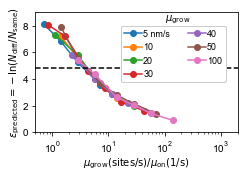

In [10]:
#also, think about what times mean here more
figure(figsize=(3.5,2.5))
#remember, v_pol in nm per second
for idx, extension_rate in enumerate(extension_rates):
    if idx == 0: 
        labelstring="%.f nm/s"
    else:
        labelstring="%.f"
    plot(extension_rate/np.array(kons)/site_width, all_energies[idx],
         label=labelstring%extension_rate,marker='o')

xlabel('$\\mu_\mathrm{grow} (\\mathrm{sites}/\\mathrm{s}) /\\mu_\\mathrm{on} {\\rm (1/s)}$',labelpad=1)


legend(fontsize=9,handletextpad=0.1,numpoints=1,ncol=2,framealpha=1,bbox_to_anchor=(.4, .38))
ax=plt.gca()
ax.annotate('$\\mu_\mathrm{grow}$',xy=(100,8.4),fontsize=10)

xscale('log')
xlim(0.5,2000)
ylim(0,9)
yticks(np.arange(0,10,2))
ylabel('$\epsilon_{\\mathrm{predicted}}=-\mathrm{ln}(N_{\\rm diff}/N_{\\rm same})$',labelpad=1)
axhline(4.8,linestyle='--',color='k')
tight_layout()
if outdir is not None: savefig(os.path.join(outdir,'epsilon_collapse_voverk.pdf'), transparent='true')

Running until length reaches 15.000000 microns / 428 sites
competition parameter  4.416721440387478
Running until length reaches 15.000000 microns / 428 sites
competition parameter  4.082388677875137
Running until length reaches 15.000000 microns / 428 sites
competition parameter  4.100553226740677
Running until length reaches 15.000000 microns / 428 sites
competition parameter  4.75364180647039
Running until length reaches 15.000000 microns / 428 sites
competition parameter  5.30529053206129
Running until length reaches 15.000000 microns / 428 sites
competition parameter  5.785567475057708


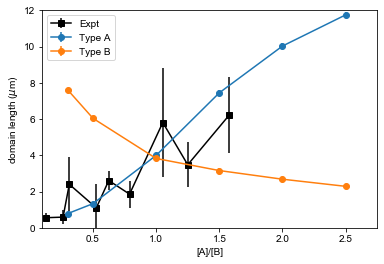

In [11]:
mymu = 40.
mykon2 = 0.2
my_num_trials=1000

energies = []
avg_domain_lengths = [[],[]]
std_domain_lengths = [[],[]]

kratio_list = (0.3,0.5,1.0,1.5,2.0,2.5)

#winkelman curr biol 2016 paper
expt_data_txt = \
"""0.12500 0.55600 0.25000
0.26316 0.58947 0.38900
0.31250 2.4000 1.5000
0.52632 1.1000 1.3000
0.62500 2.6077 0.50000
0.78947 1.8579 0.75000
1.0526 5.8100 3.0200
1.2500 3.4800 1.2500
1.5789 6.2250 2.1200"""
expt_data = np.fromstring(expt_data_txt, sep=" ").reshape((-1,3))

for kratio in kratio_list:
    ratio, ratio_std,domain_lengths,domain_types,_,_,_,_ = extension_population_ratio(num_trials=my_num_trials,
                                                                extension_rate=mymu,
                                                                kon1=mykon2*kratio,kon2=mykon2,max_filament_length=15000)
    avg_domain_lengths[0].append(domain_lengths[domain_types==1].mean())
    avg_domain_lengths[1].append(domain_lengths[domain_types==2].mean())
    std_domain_lengths[0].append(jackknife(domain_lengths[domain_types==1]))
    std_domain_lengths[1].append(jackknife(domain_lengths[domain_types==2]))
    energies.append(-np.log(ratio))
    print("competition parameter ",energies[-1])

plt.figure()
plt.errorbar(expt_data[:,0],expt_data[:,1],expt_data[:,2],label="Expt",marker='s',color='k')
plt.errorbar(kratio_list,np.array(avg_domain_lengths[0])/1e3,np.array(std_domain_lengths[0])/1e3,label="Type A",marker='o')
plt.errorbar(kratio_list,np.array(avg_domain_lengths[1])/1e3,np.array(std_domain_lengths[0])/1e3,label="Type B",marker='o')
xlim(0.1,2.75)
ylabel('domain length ($\mu$m)')
xlabel('[A]/[B]')
ylim(0,12)
legend(loc=0)


competition_prediction_data = np.array( (kratio_list, avg_domain_lengths[0],std_domain_lengths[0],avg_domain_lengths[1], std_domain_lengths[1]) ).T

Running until length reaches 15.000000 microns / 428 sites
rate: 2.500000 competition: 10.877529
Running until length reaches 15.000000 microns / 428 sites
rate: 5.000000 competition: 9.293285
Running until length reaches 15.000000 microns / 428 sites
rate: 10.000000 competition: 7.180276
Running until length reaches 15.000000 microns / 428 sites
rate: 20.000000 competition: 5.516010
Running until length reaches 15.000000 microns / 428 sites
rate: 50.000000 competition: 3.748635
Running until length reaches 15.000000 microns / 428 sites
rate: 100.000000 competition: 2.726504


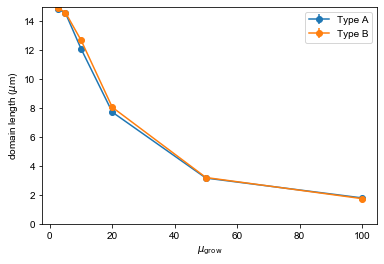

In [12]:
mymu = 40.
mykon2 = 0.2
my_num_trials=1000

energies = []
avg_domain_lengths_mu = [[],[]]
std_domain_lengths_mu = [[],[]]

kratio = 1.0
extension_list = [2.5,5.0,10.0,20.0,50.0,100.0]

for extension_rate in extension_list:
    ratio, ratio_std,domain_lengths,domain_types,_,_,_,_ = extension_population_ratio(num_trials=my_num_trials,
                                                                extension_rate=extension_rate,
                                                                kon1=mykon2*kratio,kon2=mykon2,max_filament_length=15000)
    avg_domain_lengths_mu[0].append(domain_lengths[domain_types==1].mean())
    avg_domain_lengths_mu[1].append(domain_lengths[domain_types==2].mean())
    std_domain_lengths_mu[0].append(jackknife(domain_lengths[domain_types==1]))
    std_domain_lengths_mu[1].append(jackknife(domain_lengths[domain_types==2]))
    energies.append(-np.log(ratio))
    print("rate: %f competition: %f"%(extension_rate,energies[-1]))
        
plt.figure()
plt.errorbar(extension_list,np.array(avg_domain_lengths_mu[0])/1e3,np.array(std_domain_lengths_mu[0])/1e3,label="Type A",marker='o')
plt.errorbar(extension_list,np.array(avg_domain_lengths_mu[1])/1e3,np.array(std_domain_lengths_mu[0])/1e3,label="Type B",marker='o')
ylabel('domain length ($\mu$m)')
xlabel('$\mu_\mathrm{grow}$')
ylim(0,15)
legend(loc=0)


competition_prediction_data = np.array( (extension_list, avg_domain_lengths[0],std_domain_lengths[0],avg_domain_lengths[1], std_domain_lengths[1]) ).T

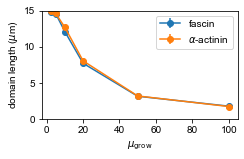

In [13]:
plt.figure(figsize=(3.5,2))
plt.errorbar(extension_list,np.array(avg_domain_lengths_mu[0])/1e3,np.array(std_domain_lengths_mu[0])/1e3,label="fascin",marker='o')
plt.errorbar(extension_list,np.array(avg_domain_lengths_mu[1])/1e3,np.array(std_domain_lengths_mu[0])/1e3,label="$\\alpha$-actinin",marker='o')

ylabel('domain length ($\mu$m)')
xlabel('$\mu_\mathrm{grow}$')

ylim(0,15)
legend(loc=0)

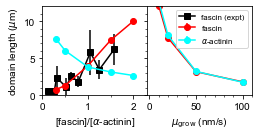

In [14]:
fig, ax = subplots(1,2,figsize=(3.7,2),sharey=True)

ax[0].errorbar(expt_data[:,0],expt_data[:,1],expt_data[:,2],label="fascin (expt)",marker='s',color='k')
ax[0].errorbar(kratio_list[:-1],np.array(avg_domain_lengths[0])[:-1]/1e3,np.array(std_domain_lengths[0])[:-1]/1e3,label="fascin",marker='o',color='red')
ax[0].errorbar(kratio_list[:-1],np.array(avg_domain_lengths[1])[:-1]/1e3,np.array(std_domain_lengths[0])[:-1]/1e3,label="$\\alpha$-actinin",marker='o',color='cyan')
ax[0].set_xlim(0.1,2.3)
ax[0].set_ylabel('domain length ($\mu$m)')
ax[0].set_xlabel('[fascin]/[$\\alpha$-actinin]')
ax[0].set_ylim(0,12)

ax[1].axhline(-1,label="fascin (expt)",marker='s',color='k')
ax[1].errorbar(extension_list,np.array(avg_domain_lengths_mu[0])/1e3,np.array(std_domain_lengths_mu[0])/1e3,label="fascin",marker='o',color='red')
ax[1].errorbar(extension_list,np.array(avg_domain_lengths_mu[1])/1e3,np.array(std_domain_lengths_mu[0])/1e3,label="$\\alpha$-actinin",marker='o',color='cyan')

ax[1].set_xlabel('$\mu_\mathrm{grow}$ (nm/s)')
ax[1].legend(loc=0,fontsize=8)


ax[0].set_xticks(np.arange(0,2.5,1))
ax[0].set_xticks(np.arange(0,2.5,.5),minor=True)

ax[0].set_yticks(np.arange(0,12,5))
ax[0].set_yticks(np.arange(0,12,1),minor=True)

ax[1].yaxis.set_label_position("right")

ax[1].set_xticks(np.arange(0,120,50))
ax[1].set_xticks(np.arange(0,120,10),minor=True)

tight_layout()
fig.subplots_adjust(hspace=0,wspace=0)

if outdir is not None: savefig(os.path.join(outdir,'domain_length_density_and_growth_kon0.2.pdf'),transparent='true')